# Exploring subcritical travelling waves for the Fisher-KPP equation

#### What's new?

18-12-29: *Added [discussion](#intersection_bc_num_discussion) how for SCENARIO I-III the parameters  affect the wave speed*

18-12-28: *Fixed typo in boundary condition.*

#### Introduction
This jupyter notebook presents a numerical solution to the Fisher ODE,
which describes the shape of the travelling wave in the Fisher-KPP equation.

$$
\begin{cases}
       U' = V \\
       V' = - f(U)/D_1 - c V/D_1
\end{cases}
\qquad
U(-\infty) = 1,\;
V(-\infty) = 0
$$

Here we consider values $ 0 \leq c \leq c_{critical}$ - usually travelling waves do not exist in this parameter range (since $U$ becomes negative eventually), 
but they do appear in the *Pushing the Boundary* model with an explicitly moving boundary.

The idea is to cut off the solution as soon as we intersect a straight line in the $U$-$V$ plane, the *slope given by the boundary condition* 

$$ V_0 = \frac{b}{D_1} U_0$$

where 
$$
b(c) = c \Big[ -1 + \big( 1 - \frac{1}{2} ( 1 + \sqrt{1 + 4 D_2 m / c^2}) \big) \frac{D_1 \alpha_2}{D_2 \alpha_1}  \Big]
$$


*Note that in a first version of this notebook, this boundary condtition was mispelled. JF, 18-12-28*

#### What do we do here?

Our goal is to find an expression for this intersection point $(U_0,V_0)$ as a function of $c$.
As no explicit solution seems to be available, we use simulations.

Note that we restrict ourselves to a logistic growth function $f(x) := x\cdot(1-x)$, but the simulations can be easily adapted [below](#fisher_ode) if one wants to look at a Allee-type growth function.

#### How to use this notebook?

1. The so-called cells (code or text) are executed one after another by clicking on the button 'Run' or clicking on the cell and then pressing 'Shift-Enter'. Then the python kernel in the background reads the statements, producing the output. 
2. To edit the code just click on a cell - leave the insert mode with 'Esc' or execute directly with 'Shift-Enter'.

*Be aware that the cells must be executed in order: the lower cells require functions defined [above](#start_here). If anything is stuck you can start afresh an click in the top tool bar on 'Kernel -> Restart & Clear Output'.*

#### So where are the results?
1. Starting with plotting [the intersection as a function of $c$](#intersection_bc_vs_c) we can get a feeling what kind of wave speeds $ c = B(U_0(c),V_0(c))$ are admissable.
2. This is discussed in 
[Discussion: What is the wave speed $c$ given by the implict equation?](#intersection_bc_num_discussion)
3. The last chapter discusses how to [Approximate the intersection with sub- and supersolutions](#intersection_bc_sub-super)

## Table of contents
*This table of contents allows you to jump to any of the sections. Note that for the code to work, in general all cells above it should have been executed.*

1. [Implementing the mathematical model](#model)
    1. [The Fisher ODE](#fisher_ode)
    2. [The boundary condition](#def_bc)
    3. [Plot: the boundary condition as a function of $c$](#plot_bc_vs_c)


2. [Numerical simulation of the ODE](#numerical_sim)
    1. [Using the built-in ODE solver](#build_ode_wrapper)
    2. [Plotting the solution curve](#plot_num_sim)
        1. [Example: How to plot for $c=1$ ?](#plot_num_sim_ex1)
        2. [Example: How to get a smoother plot?](#plot_num_sim_smooth)


3. [Approximate the intersection numerically](#intersection_bc)
    1. [Using a built-in zero finder](#intersection_bc_num)
    2. [Plotting the intersection for a given solution](#intersection_bc_plots)
        1. [Example: How to plot for $c=1$ ?](#intersection_bc_plots_ex1)
        2. [Plot: Interactive Plot varying $c$ and $D_2$](#intersection_bc_plots_interactive)
    3. [Plot: the intersection as a function of $c$](#intersection_bc_vs_c)
    4. [Discussion: What is the wave speed $c$ given by the implict equation?](#intersection_bc_num_discussion)

    
4. [Approximate the intersection with sub- and supersolutions](#intersection_bc_sub-super)
    1. [A first subsolution : set $c=0$](#intersection_bc_sub)
        1. [Plot: Subsolution intersection vs. true intersection for c=1](#intersection_bc_sub_c1)
        2. [Plot: Subsolution intersection vs. true intersection as a function of $c$](#intersection_bc_sub_all_c)
        3. [Discussion: Subsolution not helpful](#intersection_bc_sub_discussion)
    2. [Finding a supersolution](#intersection_bc_super)
        1. [Trial and error: playing around with numerical solvers](#intersection_bc_super_num)

#### START EXECUTING CELLS HERE: Setting up the python environment <a name="start_here"> </a>
The first cells just configure the python environment, no output to be expected. Press 'Shift+Enter' and keep on.

In [1]:
# import dependencies
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

from ipywidgets import interact

In [2]:
# we want interactive plots using the widgets etc.
# it's probably better to call this in a cell separate from the matplotlib imports
# maybe they have to be finished before the %magic can work
%matplotlib notebook

# we define a standard figsize which uses the whole width of the screen
# may vary with screen resolution, adjust to your setup!
figsize = (9,4)

# We use a non-standard style for plots to make them look nicer
# to see all available styles, use
# print(plt.style.available)

plt.style.use('seaborn-paper')

## 1. Defining the mathematical model <a name="model"></a>
As a first step we transfer the mathematical model into python functions, which will [later](#numerical_sim) be used to simulate a solution.

### A. The Fisher ODE <a name="fisher_ode"></a>
We introduce the default growth function: the logistic growth.

In [3]:
def logistic_growth(x):
    """ Logistic growth function in vectorized notation"""
    return np.multiply(x,1-x)

We define the two-dimensional derivative of the ODE to be plugged into the ODE solver.

In [4]:
def derivative(t,y,c=1,D1=1,f=logistic_growth,**kwargs):
    """
    Returns the derivatives of the Fisher-ODE as needed for np.scipy.solve_ivp
    
    Inputs
    ------
    t    positive scaler, time
    y    array of shape (2,k)
    c    positive scalar, wave speed
    D1   positive scalar, diffusion coefficient
    f    scalar function, mapping state U to growth rate f(U)
    
    Returns
    -------
    y_prime  array of length (2,k)
    
    Example
    -------
    >>> U = np.ones(3)
    >>> V = np.ones(3)*0
    >>> y = np.stack((U,V))
    >>> print(derivative(t=1,y,c=2))
    [[ 0.  0.  0.]
     [-0. -0. -0.]]
    """
    # unpack the two variables
    U = y[0]
    V = y[1]
    
    #calculate derivative using usual notation
    U_prime = V
    V_prime = -f(U)/D1 - c*V/D1
    
    # pack return variable
    y_prime = np.zeros(y.shape)
    y_prime[0] = U_prime
    y_prime[1] = V_prime
    
    return y_prime

### B. The boundary condition <a name="def_bc" ></a>

We define the slope of the straight line $V(c)= b/D_1 U(c)$ through a function

    def slope_bc(c): 
        return b(c)/D1
        
This will allow us to calculate the point of intersection with the numerical solution.
      

In [5]:
def b(c=1,D1=1,D2=1,alpha1=1,alpha2=1,m=1,**kwargs):
    """Returns b(c) as it appears in the slope associated to the boundary condition"""
    
    # Check that all parameters are positive 
    for var in [c,D1,alpha2,m]:
        assert var >=0, "Variable must be greater or equal than zero"
    for var in [D2,alpha1]:
        assert var > 0, "Variable must be greater than zero"
        
    # we define an auxiliary variable, just as in the script on page 7 (eq. 41)
    # script version 18-08-28
    nu_minus = ( - c - np.sqrt(c**2 + 4*D2*m))/(2*D2)
    b = -c + (D2*nu_minus +c)*(D1*alpha2)/(D2*alpha1)
    return b

def slope_bc(c=1,D1=1,D2=1,alpha1=1,alpha2=1,m=1,**kwargs):
    """Returns slope such that V_0 = slope_bc * U_0 """
    denominator = D1
    nominator = b(c=c,D1=D1,D2=D2,alpha1=alpha1,alpha2=alpha2,m=m,**kwargs)
    assert denominator != 0, "Slope of boundary condition is infinite!"
    return nominator/denominator

### C. Plotting the slope of the boundary condition as a function of $c$ <a name ="plot_bc_vs_c" ></a>

As a first example, we plot how the slope of the boundary condition varies with $c$ and $D_2$. 

<IPython.core.display.Javascript object>


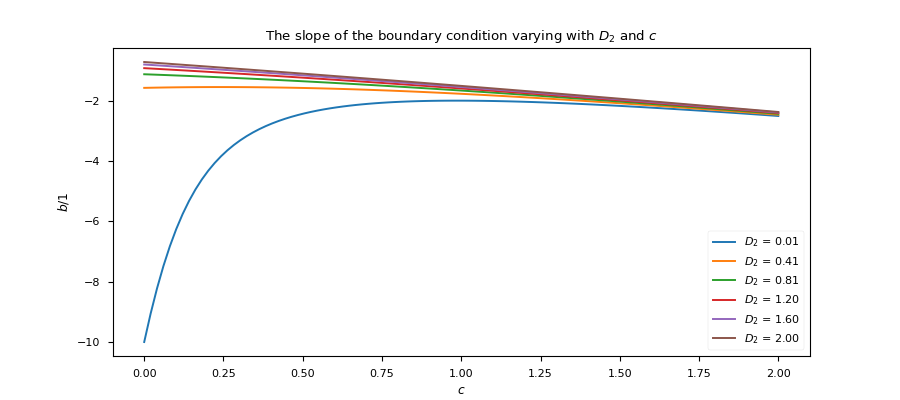

In [6]:
# setting the critical wave speed
c_crit = 2
# setting the range of c values to be plotted
c_range = np.linspace(0,2,100)
# setting the range of D_2 values to be plotted
D2_range = np.linspace(0.01,2.0,6)
# setting up the figure
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
ax.set_title("The slope of the boundary condition varying with $D_2$ and $c$")
ax.set_xlabel(r"$c$")
ax.set_ylabel(r"$b/1$")   
# plot 
for D2 in D2_range:
    slope_range = [slope_bc(c=c,D2=D2) for c in c_range]
    ax.plot(c_range,slope_range, label = "$D_2$ = %.2f" % D2)

    
_ = ax.legend(loc="lower right")

##### Discussion of the plot

The numerical simulations have been performed with the default parameters $D_1 = 1$, $\alpha_1 = 1$, $\alpha_2=2, m=1$,
see the definition of 
    
    slope_bc(c)
    
as a Python callable in the cell [above](#def_bc).

The nonlinearity for small $D_2$ arises because 
$$ 
b(c) \sim \mathcal{O}(1/D_2^2)
\qquad
\text{as }
D_2 \to 0
$$
as a Taylor expansion of $b$ as a function of $D_2$ shows.

Interestingly enough, this nonlinearity does not appear [later](#intersection_bc_vs_c) when we plot the point of intersection $(U_0(c),V_0(c))$ as a function of $c$.

## 2. Numerical Simulation <a name="numerical_sim"></a>

Since no explicit solution for the Fisher ODE seems to be available for (only for $c=\frac{5}{\sqrt{6} > 2$),
we solve the initial value problem numerically.

### A. Using the ODE solver from the scipy library <a name="build_ode_wrapper"> </a>

The python ecosystem provides the scipy library for scientific computing, it includes an ODE solver.
To use it here we define a wrapper function 'get_solution' for it, which takes care of plugging in the right parameters in the right places.

In [7]:
def get_solution(max_step = 5e-1,**kwargs):
    """ Returns solution to Fisher ODE
    INPUTS
    ------
    max_step    maximum time step: the smaller, the smoother the plot
    **kwargs    an number of keyword arguments, to be passed to the mathematical model
    """
    # maximum time for simulation 
    # in most cases this will not be effective due to the event below
    T = 1e2 
    # initial value
    # we need to add a little disturbance from equilibrium
    U_0 = 1
    V_0 = 0 - 1e-7

    ### EVENTS
    # We define a series of events for which we want to determine the exact point in time when they occur
    # When do we hit the horizontal U-axis again ?
    def hit_Uaxis(t, y): return y[1]
    # we stop when we first cross the  U-axis again and V becomes positive
    # this saves us computation time
    hit_Uaxis.terminal = True
    hit_Uaxis.direction = 1
    
    # collect all events
    events = [hit_Uaxis]
    
    ### DEFINE WRAPPER FUNCTION
    # Wrapper to plug derivative with non-standard parameters into solve_ivp
    def fun(t,y):
        return derivative(t,y,**kwargs)

    ### CALL BUILT-IN ODE SOLVER
    # we want to evaluate the solution at any point in time, hence we set dense_output = True
    sol = solve_ivp(fun,(0,T),np.array([U_0,V_0]), vectorized=True, method='Radau', events=events,max_step = max_step,\
                    dense_output= True)
    return sol

### B. Plot the solution curve and wave profile <a name="plot_num_sim"></a>

We introduce a set of plot functions, which for technical reasons are factored into different subroutines to allow interactive plots, too.

In [8]:
def get_opts_string(opts):
    """Returns the parameter values in opts as string"""
    parameter_string = ""
    for key,value in opts.items():
        parameter_string = parameter_string + key + str("=%.1f " %value)
    return parameter_string

def get_figure_title(opts):
    """ Returns a meaningful title for figure"""
    txt = "Numerical simulation with parameters: " + get_opts_string(opts)
    return txt

def clear_lines(ax):
    """ clears  all lines from an axe"""
    for line in ax.get_lines():
        line.remove()

def add_sol_curve_to_plot(sol,ax, clear=False, **kwargs):
    """adds the solution curve in the U-V plane to a plot"""
    # for notational purposes we unpack the solution
    U = sol.y[0]
    V = sol.y[1]
    
    if clear: clear_lines(ax)
    
    ax.plot(U,V,**kwargs)
    return ax

def plot_sol_curve(sol,ax,**kwargs):
    """initializes an axe to plot the solution curve"""
    # set spine position
    spines = ax.spines
    spines['left'].set_position(('data',0.0))
    spines['bottom'].set_position(('zero'))
    spines['right'].set_visible(False)
    spines['top'].set_visible(False)
    # set axis labels
    ax.set_xlabel(r"$U$")
    ax.set_ylabel(r"$V$")
    # set title
    ax.set_title("The solution curve")
    
    return add_sol_curve_to_plot(sol,ax,clear=False,**kwargs)

def add_wave_profile_to_plot(sol,ax, clear=False,**kwargs):
    """adds the wave profile to a plot"""
    # for notational purposes we unpack the solution
    U = sol.y[0]
    t = sol.t
    
    if clear: clear_lines(ax)
    
    return ax.plot(t,U,**kwargs)

def plot_wave_profile(sol,ax,**kwargs):
    """initializes an axe to plot the wave profile"""
    # set labels
    ax.set_xlabel(r"$z$")
    ax.set_ylabel(r"$U(z)$")
    # set title
    ax.set_title("The travelling wave profile")
    return add_wave_profile_to_plot(sol,ax,clear=False,**kwargs)


def plot_summary(sol,opts):
    """plots a summary for a given solution"""
    fig = plt.figure(figsize=figsize)
    fig.suptitle(get_figure_title(opts),wrap=True,fontsize=10)
    
    # To the left we plot the solution curve
    ax1 = fig.add_subplot(1,2,1)
    plot_sol_curve(sol,ax1)
    
    #To the right we plot the wave profile
    ax2 = fig.add_subplot(1,2,2)
    plot_wave_profile(sol,ax2)
    
    return

#### Example plot 1: pass the parameters as keyword arguments <a name="plot_num_sim_ex1"> </a>

We present a small example to show how to use the routines defined above to calculate and plot the numerical solution.

<IPython.core.display.Javascript object>


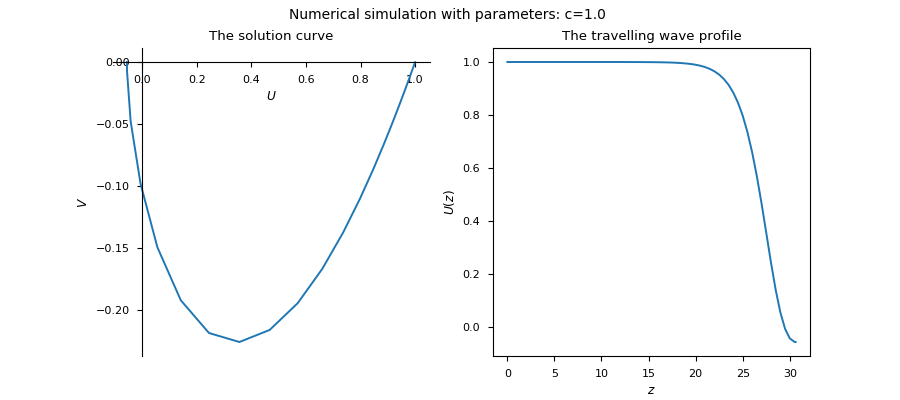

In [9]:
# We plot the solution for c=1
sol = get_solution(c=1)
plot_summary(sol,dict(c=1))

#### Example plot 2: pass arguments using a python dictionary --- and get a smooth plot by tuning max_steps <a name="plot_num_sim_smooth"> </a>

In fact, we can pass any parameter to the routines through specifying them in a dictionary (this is a built-in data structure). As a demonstration we show how to adjust the parameter 'max_steps' to get a smoother plot.

<IPython.core.display.Javascript object>


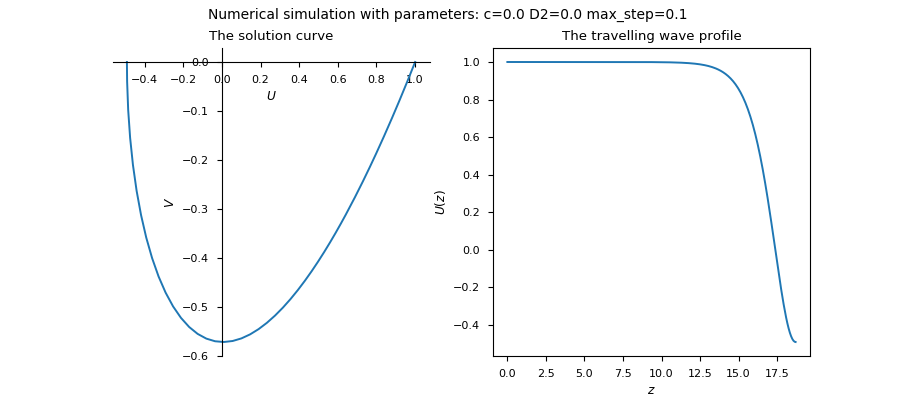

In [10]:
# Alternative notation
# We define the parameters as a dictionary
# to get a smooth plot, we set max_step smaller  
opts = dict(c = 0.01, D2 = 0.01, max_step = 8e-2)
sol = get_solution(**opts)
plot_summary(sol,opts)


## 3. Approximate the intersection point between solution curve and boundary condition numerically <a name="intersection_bc" ></a>

The boundary condition between the two different habitats 
is satisfied along the straight line 

$$
V(U) = \text{slope_bc}(c) \cdot U : = b(c)/D_1  \cdot U
$$ 

in the $U$-$V$ plane.


As shown in the draft *Pushing the boundaries* we can expect for any $ c \in [0,c_{crit}) $ that the solution curve $(U(z), V(z))$ intersects the line at a point $(U_0(c),V_0(c)$.
We need to determine this intersection point as a function of $c$ to be able to identify the solution to the implicit equation 

$$
c = B(U_0(c),V_0
$$

in the next section.

##### Remark: different notation in the code

In the code we use a different notation, we write 

    U_bc, V_bc

for $U_0,V_0$ to distinguish it from the initial condition of the ODE solver $(1,0)$.

Hence we will use the symbols $U_{bc} := U_0$ and $V_{bc} : = V_0$ interchangeably.

###  A. Using built-in zero finder <a name="intersection_bc_num"></a>

Our first approach is to get the intersection point $U_{bc},V_{bc}$  for a given $c$ from the numerical solution.
To this end we use a built in zero finder from the scipy library.

In [11]:
from scipy.optimize import brentq as find_zero

def get_bc_intersection(sol, slope_bc):
    """Returns coordinates of intersection between solution curve and V = slope_bc * U"""
    def distance_to_bc(t):
        U,V = sol.sol(t)
        return V - slope_bc*U
    
    #t_zero = find_zero(distance_to_bc, xin=1)
    t_zero = find_zero(distance_to_bc,sol.t[0],sol.t[-1])
    # print("t_zero = %f" % t_zero)
    return sol.sol(t_zero)

### B. Define python routines for plotting the intersection point <a name="intersection_bc_plots"> </a>

To plot the intersection point we introduce auxiliary functions.

In [12]:
def plot_bc_slope(slope_bc,ax, **kwargs):
    """Plots the slope associated to the boundary condition"""
    x = np.linspace(0,1,10)
    y = slope_bc*x
    ax.plot(x,y,**kwargs)
    
    return ax

def plot_intersection(sol,slope_bc,ax, **kwargs):
    """Plot the solution curve with the intersection line"""
    # plot solution curve
    ax = plot_sol_curve(sol,ax, color = 'b', **kwargs)
    # plot slope coming from bc
    ax = plot_bc_slope(slope_bc,ax,linestyle = 'dashed',color ='k',label='boundary condition')
    #plot point of intersection
    U_bc, V_bc = get_bc_intersection(sol,slope_bc)
    ax.plot(U_bc,V_bc,'ro',label = 'point of intersection')
    # plot the legend
    ax.legend(loc='lower right')
    
    return ax

#### Example plot 1: plot the intersection for a given c <a name="intersection_bc_num_plot_ex1"></a>

<IPython.core.display.Javascript object>


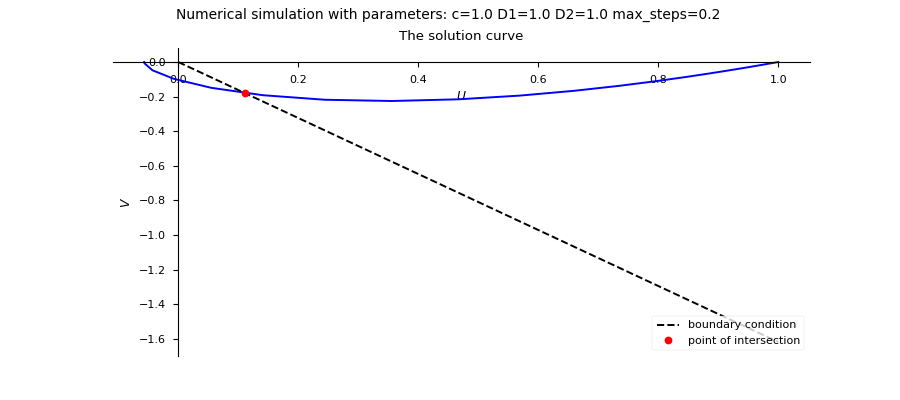

In [13]:
# define parameters in a dictionary
opts = dict(c=1,D1=1,D2=1, max_steps=2e-1)
# compute solution
sol = get_solution(**opts)

# setup the figure
fig = plt.figure(figsize=figsize)
fig.suptitle(get_figure_title(opts), wrap = True, fontsize=10)
ax = fig.add_subplot(1,1,1)
ax = plot_intersection(sol,slope_bc(**opts),ax)

#### Example plot 2: plot the intersection interactively <a name="intersection_bc_plots_interactive">
We now add sliders for $c$ and $D_2$ to the plot, which updates interactively as we move the knob.

<IPython.core.display.Javascript object>


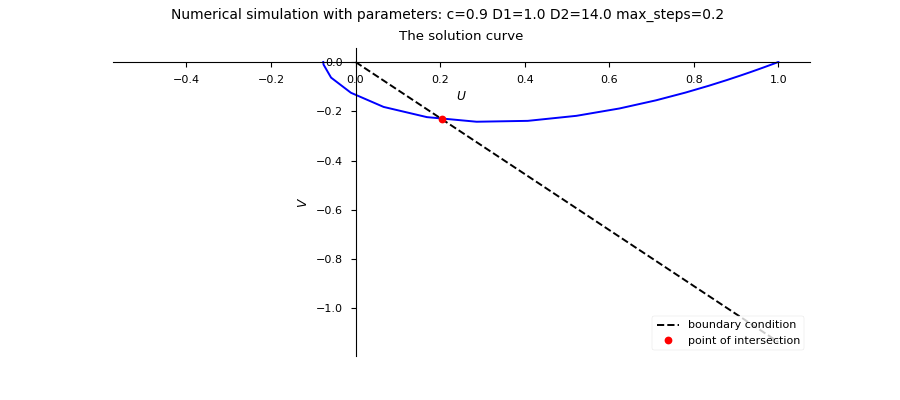

interactive(children=(FloatSlider(value=0.8999999999999999, description='c', max=3.0, step=0.15), FloatSlider(…

In [14]:
# define parameters in a dictionary
opts = dict(c=0,D1=1,D2=1, max_steps=2e-1)
# compute solution
sol = get_solution(**opts)

# setup the figure
fig = plt.figure(figsize=figsize)
fig.suptitle(get_figure_title(opts),wrap=True,fontsize=10)
ax = fig.add_subplot(1,1,1)
ax = plot_intersection(sol,slope_bc(**opts),ax)

def update(c = (0,3,0.15), D2= (0.01,30,1)):
    opts['D2']=D2
    opts['c'] = c
    sol = get_solution(**opts)
    clear_lines(ax)
    _ = plot_intersection(sol,slope_bc(**opts),ax)
    fig.suptitle(get_figure_title(opts),wrap=True,fontsize=10)

    
interact(update);

### C. Plotting the intersection coordinates as a function of $c$ <a name="intersection_bc_vs_c"></a>

We plot the two intersection points $U_{bc}(c)$ and $V_{bc}(c)$ as functions of $c$ for different values of $D_2$.

**WARNING**
*Note that this may be a computationally more expensive plot. If it takes too long, set max_step to something larger, i.e. 5e-1.*
*To give an idea how long it would take to re-execute the cell we print the duration by prepending*

    %time ....get solutions for all c

*which will print the time it takes to compute the solutions for all c.*

In [15]:
# setting the critical wave speed
c_crit = 2
# setting the range of c values to be plotted
c_range = np.linspace(0,c_crit - 1e-2,10)
# setting the range of D_2 values to be plotted
D2_range = np.linspace(0.01,2.0,4)

# setting the other options
# all options possible besides c and D2
opts = dict(max_step = 1e-1, D1=1,alpha1=1,alpha2=1, m =1)

# calculating the solutions
# we print the execution time: this is a costly operation so you can estimate
# how long it would take to run this cell again (look for Wall time)
%time sol_range = [get_solution(c=c,**opts) for c in c_range]


CPU times: user 4.12 s, sys: 10.4 ms, total: 4.13 s
Wall time: 4.15 s


<IPython.core.display.Javascript object>


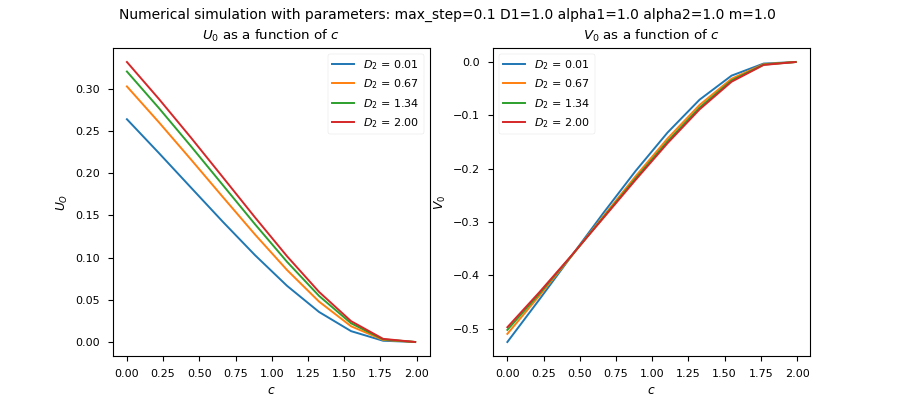

In [16]:
# setting up the figure
fig = plt.figure(figsize=figsize)
fig.suptitle(get_figure_title(opts),wrap=True, fontsize=10)
# we plot the values U_bc to the left
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r"$c$")
ax1.set_ylabel(r"$U_O$")
ax1.set_title(r"$U_0$ as a function of $c$")
# we plot the values V_bc to the right
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel(r"$V_0$")
ax2.set_title(r"$V_0$ as a function of $c$")


# plot 
for D2 in D2_range:
    # calculate the intersection coordinates
    intersection_bc_range = np.array([get_bc_intersection(sol=sol,slope_bc=slope_bc(**opts, D2=D2)) for sol in sol_range])
    U_bc_range = intersection_bc_range[:,0]
    V_bc_range = intersection_bc_range[:,1]
    ax1.plot(c_range,U_bc_range, label = "$D_2$ = %.2f" % D2)
    ax2.plot(c_range,V_bc_range, label = "$D_2$ = %.2f" % D2)

ax1.legend(loc = "upper right")
_ = ax2.legend(loc="upper left")
    

### D. Discussion: What is the wave speed $c$ given by the implicit equation ? <a name="intersection_bc_num_discussion"></a>

In the draft *Pushing the boundary* the precise wave speed $c$ from the range $[0,c_{crit}]$ is given by the implicit
equation

$$
c = B(U_0(c),V_0(c))
$$

where $B: \mathbb{R}^2 \to \mathbb{R}$ is a function given through a careful analysis of the behaviour
of the individuals at the boundary.

**QUESTION ONE** *For what choices of $B$ does the impilicit equation have a solution?*

**Answer**

We know by the boundary condition that $V_0 = b/D_1 \cdot U_0$ and think of $B$ as a function of $U_0$ only.
As long as this function 

$$ B : U_0 \mapsto B(U_0, b/D_1 \cdot U_0)$$

satisfies $B(0)=0$ and is monotonely increasing in $U_0$ the plot above suggests that we have an intersection.
To see this it is useful to reverse the axes in the plot above and plot $c$ as a function of $U_0(c)$.

<IPython.core.display.Javascript object>


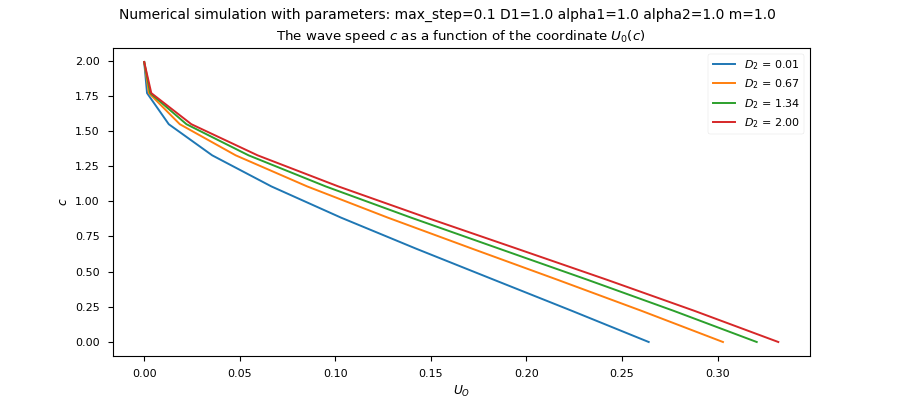

In [17]:
# setting up the figure
fig = plt.figure(figsize=figsize)
fig.suptitle(get_figure_title(opts),wrap=True, fontsize=10)
# we plot the values U_bc to the left
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel(r"$c$")
ax1.set_xlabel(r"$U_O$")
ax1.set_title(r"The wave speed $c$ as a function of the coordinate $U_0(c)$")

# plot 
for D2 in D2_range:
    # calculate the intersection coordinates
    intersection_bc_range = np.array([get_bc_intersection(sol=sol,slope_bc=slope_bc(**opts, D2=D2)) for sol in sol_range])
    U_bc_range = intersection_bc_range[:,0]
    ax1.plot(U_bc_range,c_range, label = "$D_2$ = %.2f" % D2)
   
_ = ax1.legend(loc = "upper right")


**QUESTION TWO** *How does the wave speed change as a function of the parameters?*

The draft *Pushing the boundary* discusses three different scenarios for $B$, in all cases it
is a bilinear function 

$$ B : (U_0, V_0) \mapsto \bar{B}_0 + \bar{B}_U \cdot U + \bar{B}_V \cdot V $$

for three constants $\bar{B}_0, \bar{B}_U , \bar{B}_V \in \mathbb{R}$.

Using again the fact that $V_0$ is a constant multiple of $U_0$, this reduces to

$$ B: U_0 \mapsto \bar{B_0} + \big[ \bar{B}_U + D_1/b \cdot \bar{B}_V \big] \cdot U $$

**Answer**

1. For **SCENARIO I** we have $\bar{B}_0 = \bar{B}_V= 0$ and  $\bar{B}_U > 0$. This gives an increasing function of $U_0$ and a point of intersection exists. The larger the constant $\bar{B}_U$, the greater the wave speed. In the biological context of **SCENARIO I** this means, that the more individuals stay at the boundary in their random walk ($\alpha = 1 - \alpha_1 - \alpha_2$ is large), the faster the boundary moves. This makes sense, if more beavers at the boundary means more work is put into preparing the uncolonized wilderness $x > L(t)$.



2. For **SCENARIO II** we have $\bar{B}_V = 0$, $\bar{B}_U > 0$ and $\bar{B}_0 <0$. This is supposed to model a situtation where the boundary only starts moving, if the population $U_0$ exceeds a threshold $\bar{u}$. This constant $\bar{u}$ cannot be too negative, since for a point of intersection it is required that 

$$\bar{B}_0 \geq  - \bar{B}_U \cdot \max_{c \in [0,c_crit]} U_0(c) = - \bar{B}_U \cdot U_0(c=0)$$

In the concrete case of **SCENARIO II** *(see equation (17) on page 5 in the 18-08-28 version of the draft)* this boils down to 

$$ \bar{u} \leq U_0(c=0)$$

which makes perfect sense. If the threshold is higher than any possible boundary value $U_0(c)$, there is no travelling wave. 
*Note that $U_0(c=0)$ can be explicitly calculated, see the section on the [subsolution](#intersection_bc_sub).*

Furthermore observe, that as $\bar{u}$ increases, $\bar{B}_0$ decreases and the wave speed decreases as well.
In the biological context this is natural, since a high threshold density should indicate that moving the boundary
is somewhat costly and thus slow.

3. For **Scenario III** we have $\bar{B}_0 = \bar{B}_U = 0$ and $\bar{B}_V < 0$. Since $b/D_1$ is negative,
the function as a whole is monotonely increasing in $U_0(c)$ and the implicit equation has a solution.
The larger $|\bar{B}_V|$, the faster the wave speed.
Observe that if $\bar{B}_U > 0$ is large enough, even a positive value $\bar{B}_V$ could be possible.

*TODO: make for each scenario a sample plot in the $U_0$ - $c$ plane*

## 4. Approximate the intersection by sub - and supersolutions <a name="intersection_bc_sub-super"></a>

*This section is definitely work in progress. JF, 18-12-28*

The idea here is to find two functions $V^{super}(U)$ and $V^{sub}(U)$ such that 

$$
    V^{super} (U) \geq V(U) \geq V^{sub}(U) 
    \qquad
    \forall U \in (U_{bc},0)
$$

which we call *super* - resp. *subsolution* as their curves in the $U$-$V$ plane lie above and below the solution curve.

The true solution curve for $c$ is given by 

$$
\frac{dV}{dU} = \frac{V'}{U'} = \frac{ -f(U) - c \cdot V}{D_1 V}
\qquad
\text{with }
V(1) = 0
$$

now we look for estimates 

$$
\frac{dV^{super}}{d U} \geq \frac{-f(U) - c \cdot V}{D_1 V} \geq \frac{dV^{sub}}{dU} 
\qquad
\text{with }
V^{super}(1) = V^{sub}(1) = 0
$$

where the equations for the sub- and supersolution are expclitly solvable (use Gronwalls equation to show that they are truly sub - and supersolutions?).


Then we hope to  use the sandwich of the solution curves for a sandwich of the intersection points with the boundary condition

$$
V^{super}_{bc} \geq V_{bc} \geq V^{sub}_{bc},
\qquad
U^{super}_bc \leq U_{bc} \leq U^{sub}_{bc},
$$

which in turn would allow us to sandwich the wave speed given by $c = B(U_0(c),V_0(c))$.

### A. Finding a subsolution <a name = "intersection_bc_sub"></a>

We have already observed from above that the solution for $c=0$ is a subsolution, since it's curve lies below that of any $c > 0$. The equation

$$
\frac{dV}{dU} = \frac{-f(U)}{D_1 V}
\qquad
V(1) = 0
$$

is explicitly solvable by separation of variables and for the logistic growth function $f(x) = x\cdot(1-x)$ we get 

$$
V^{sub}(U)  = - \frac{1}{\sqrt{D_1}} \cdot \sqrt{\frac{2}{3} U^3 - U^2 + \frac{1}{3}}
$$

First we write down this exact solution as a python function.

In [18]:
def get_sub_solution(U,c=1.,D1=1.,**kwargs):
    """Returns exact subsolution (= solution for c=0)"""
    if np.allclose(U,np.ones(len(U))):
        return np.zeros(len(U))
    V_squared = 2*np.power(U,3)/3. - np.power(U,2) + 1./3.
    V =  - np.sqrt(V_squared/D1)
    return V

This could be use to produce a plot to compare the exact subsolution to the numerical solution for $c=0$,
which has been left out here for the sake of clearity.
In the following we use the numerical subsolution by just setting $c=0$ as this works the best with the plot routines.

#### a. Comparing intersection points for subsolution and true solution for $c=1$ <a name="intersection_bc_sub_c1"></a>

For a fixed $c$ we show the geometry in the $U$-$V$ plane and get a first idea, how good the approximation could be or not.

<IPython.core.display.Javascript object>


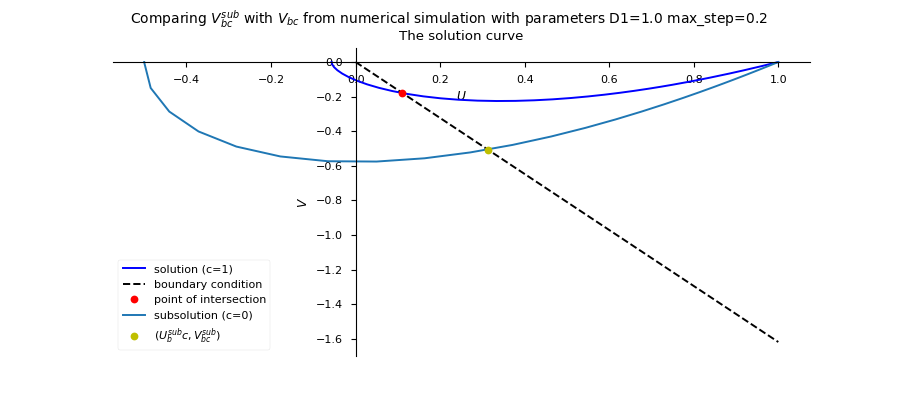

In [19]:
# setting parameters, can include all but c
opts = dict(D1=1,max_step = 2e-1)
# for easier use with the plotting routines we use numerical subsolution now
sub_sol = get_solution(c=0,**opts)
sol = get_solution(c=1, **opts)
# set up the figure
fig = plt.figure(figsize=figsize)
fig.suptitle(r"Comparing $V^{sub}_{bc}$ with $V_{bc}$ from numerical simulation with parameters "\
            + get_opts_string(opts), fontsize=10, wrap = True)
ax = fig.add_subplot(1,1,1)
# plot solution and true intersection point
ax = plot_intersection(sol,slope_bc=slope_bc(c=1,**opts), ax=ax,label="solution (c=1)")
# plot subsolution curve
ax  = add_sol_curve_to_plot(sol= sub_sol,ax=ax,label="subsolution (c=0)")
# plot intersection of boundary condition with subsolution
U_sup_bc, V_sub_bc = get_bc_intersection(slope_bc=slope_bc(c=1,**opts), sol=sub_sol)
ax.plot(U_sup_bc,V_sub_bc,'yo',label=r"$(U^{sub}_bc, V^{sub}_{bc})$")
_ = ax.legend(loc = "lower left")

#### b. Subsolution intersection $U^{sub}_{bc}(c)$  vs. true intersection $ U_{bc}(c)$ as a function of $c$ <a name="intersection_bc_sub_all_c"></a>

Now we want to compare the two intersection points for a range of possible values for $c$.
Although an analytic expression for the intersection point of the subsolution should be available here we use the brute-force approach and resort to the numerical subsolution.

**WARNING** *Again computing the solution for multiple values of c may be slow. The execution time of the last run is printed below the cell. Scale up max_step to speeden up the computation.*

In [20]:
# options should not include c
opts = dict(D1=1,max_step = 1e-1)

c_range = np.linspace(0,1.99,5)
sub_sol = get_solution(c=0,**opts)
# this is costly, so we time it
%time sol_range = [get_solution(c=_,**opts) for _ in c_range]

U_bc_range = np.zeros(len(sol_range))
V_bc_range = np.zeros(len(sol_range))

for i in range(len(sol_range)):
    U_bc_range[i], V_bc_range[i] = get_bc_intersection(sol_range[i],slope_bc(c_range[i],**opts))
    
sub_bc_intersection_range = np.array([get_bc_intersection(sub_sol,slope_bc(_,**opts)) for _ in c_range])
U_sub_bc_range = sub_bc_intersection_range[:,0]
V_sub_bc_range = sub_bc_intersection_range[:,1]

CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.26 s


<IPython.core.display.Javascript object>


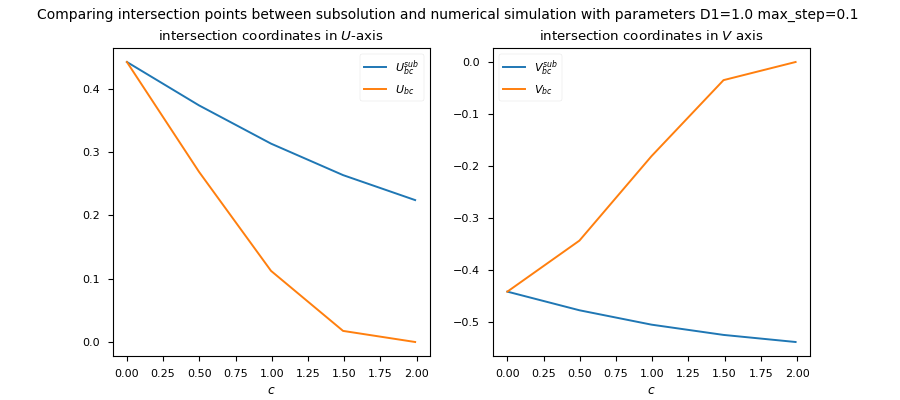

In [21]:
# We plot the dependcy of the min
fig = plt.figure(figsize=figsize)
fig.suptitle(r"Comparing intersection points between subsolution and numerical simulation with parameters "\
            + get_opts_string(opts), fontsize=10, wrap = True)
# To the left we plot the values of U_min and U_bc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title(r"intersection coordinates in $U$-axis")
ax1.set_xlabel(r"$c$")
ax1.plot(c_range,U_sub_bc_range, label=r"$U^{sub}_{bc}$")
ax1.plot(c_range,U_bc_range, label = "$U_{bc}$")
ax1.legend()
# to the right we plot the values of V_min and V_bc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title(r"intersection coordinates in $V$ axis")
ax2.set_xlabel(r"$c$")
ax2.plot(c_range,V_sub_bc_range, label = r"$V^{sub}_{bc}$")
ax2.plot(c_range,V_bc_range, label = r"$V_{bc}$")
_ = ax2.legend()

#### c. Discussion : This subsolution is not really helpful <a name="intersection_bc_sub_discussion" > </a>

Looking at the plot above we observe that the estimate is really wasteful concerning $U_{bc}$ --- here we would be better off just estimating $U_{bc}(c)$ by $U_{bc}(0)$, which we can calculate explicitly.
The estimate for $V_{bc}$ does slightly better, but again we could try and interpolate linearly between $V_{bc}(0)$ and $V_{bc}(1.99)$ --- if we could get an explicit expression for the latter!

### B. Finding a supersolution <a name="intersection_bc_super"></a>

We are looking for a supersolution (the graph in the $U$-$V$ plane is above the Fisher ODE solution) which is explicitly solvable, e.g. by separation of variable.

We could use the subsolution defined above to estimate 

$$ 
\frac{dV}{dU}  = \frac{-f(U) - c*\cdot V}{D_1 \cdot V}  \leq \frac{-f(U) - c \cdot V^{sub}(U)}{D_1 \cdot U}
$$ 
  
where we have used 

$$ V(U) \geq V^{sub}(U)$$.

#### a. Trial and Error: Playing around with numerical solvers <a name="intersection_bc_super_num" ></a>

Whereas the supersolution defined by the estimate above should be explicitly solvable by a separation of variables we use the numerical solution here. 
Again we start with a wrapper for the built-in ODE solver.

In [22]:
def get_super_solution(max_step = 2e-1,**kwargs):
    """ Returns super solution to Fisher ODE
    INPUTS
    ------
    max_step    maximum time step: the smaller, the smoother the plot
    """
    # maximum time
    # in most cases this will not be effective due to the event below
    T = 1e2 
    # initial value
    # we need to add a little disturbance from equilibrium
    U_0 = 1
    V_0 = 0 - 1e-7


    # add event to stop when we first cross the  V-axis again and V becomes positive
    # this saves us computation time
    def hit_Uaxis(t, y): return y[1]
    hit_Uaxis.terminal = True
    hit_Uaxis.direction = 1
    # collect all events
    events = [hit_Uaxis]
    
    # Wrapper to plug derivative with non-standard parameters into solve_ivp"""
    def fun(t,y):
        return super_derivative(t,y,**kwargs)

    sol = solve_ivp(fun,(0,T),np.array([U_0,V_0]), vectorized=True, method='Radau', events=events,max_step = max_step,\
                    dense_output= True)
    return sol

Then we define our derivative for the super solution.

In [23]:
def super_derivative(t,y,c=1,D1=1,delta=0, gamma = 0, f=logistic_growth,**kwargs):
    """
    Returns the super derivatives of the Fisher-ODE as needed for np.scipy.solve_ivp
    
    Inputs
    ------
    t    time, positive scalar
    y    array of shape (2,k)
    c    positive scalar, wave speed
    D1   positive scalar, diffusion coefficient
    delta   positive scalar used to adjust the ODE ad-hoc
    gamma   positive scalar used to adjust the ODE ad-hoc
    f    scalar function, mapping state U to growth rate f(U)
         default: exponential growth
    
    Returns
    -------
    y_prime  array of length (2,k)
    
    """
    # unpack the two variables
    U = y[0]
    V = y[1]
    
    #calculate derivative using usual notation
    U_prime = delta*V
    V_prime = -f(U)/(D1) - c*(get_sub_solution(U,c=c,**kwargs) + gamma)
    
    # pack return variable
    y_prime = np.zeros(y.shape)
    y_prime[0] = U_prime
    y_prime[1] = V_prime
    
    return y_prime

Note that we have introduced two ad-hoc paramters 

    gamma, delta 
    
we shape the curve in the $U$-$V$-plane.
Through trial and error we find the following candidate for a supersolution.

<IPython.core.display.Javascript object>


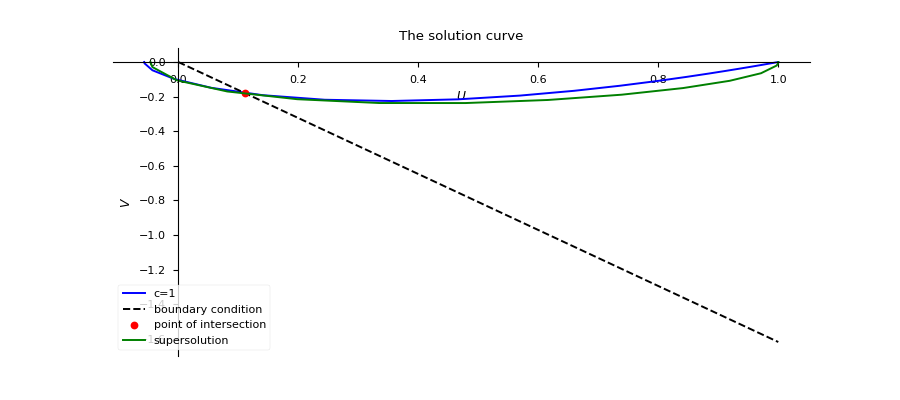

In [24]:
sol = get_solution(c=1)
super_sol = get_super_solution(c=1,delta=3, gamma = 2.2e-1)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
ax = plot_intersection(sol,slope_bc(c=1), ax = ax, label = "c=1")
ax = fig.get_axes()[0]
ax = add_sol_curve_to_plot(super_sol, ax, color='g', label = "supersolution")
_ = ax.legend(loc="lower left")

#### Discussion of supersolution

Of course this is pretty hopeless, just introducing the ad-hoc parameters is hard to argue for.

But intuitively, having the delta to increase $U'$ somehow makes sense.
By estimating $-V(U) \leq - V^{sub}$ we have increased the nominator and with 

    delta = 3
    
we can counter that effect by increasing the denominator as well.